In [1]:
# Some basic imports
import numpy as np
import pickle
import torch
import torch.nn as nn

Helper functions

In [ ]:
# Helper functions
def _one_hot(x, k, dtype=np.float32):
    """Description: Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def _standardize(x):
    """Description: Standardization per sample across feature dimension."""
    axes = tuple(range(1, len(x.shape)))
    mean = np.mean(x, axis=axes, keepdims=True)
    std_dev = np.std(x, axis=axes, keepdims=True)
    return (x - mean) / std_dev


def load_data(dataset, num_classes):
    """Description: loads mnist dataset"""
    path = f'../datasets/{dataset}/{dataset}.dump'
    with open(path, 'rb') as file:
        (x_train, y_train), (x_test, y_test) = pickle.load(file)

    # flatten x_train and x_test
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    # standardize input
    x_train, x_test = _standardize(x_train), _standardize(x_test)

    # get one hot encoding for the labels
    # y_train = _one_hot(y_train, num_classes)
    # y_test = _one_hot(y_test, num_classes)

    # get info about the numner of training and testing exammples
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]

    in_dim = x_train.shape[1]
    out_dim = num_classes

    return (x_train, y_train), (x_test, y_test), (num_train, num_test), (in_dim, out_dim)

# Problem 1: Implementing FCNs in NumPy




Task: Implement a three layer fully connected network with ReLU activation only using NumPy. Next, train the network on the MNIST dataset with Cross-entropy loss using gradient descent.

###Task: Let us begin by implementing some basic functions. Feel free to use implementations from previous homeworks.

In [83]:
def softmax(x):
    """
    Description:
        --Compute softmax(x)
    Inputs:
        --x: a 2d array of shape (batch_size, in_dim)
    Returns:
        --y: a 2d array of shape (batch_size, in_dims)
    """
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


def log_softmax(x):
    """
    Description:
        --Compute log-softmax(x)
    Inputs:
        --x: a 2d array of shape (batch_size, in_dim)
    Returns:
        --y: a 2d array of shape (batch_size, in_dims)
    """
    return np.log(softmax(x))


def xent_loss(logits, targets):
    """
    Description: Compute the Crossentropy loss using log_softmax and softmax

    Inputs:
        -- logits: logits of shape (batch_size, out_dim)
        -- targets: true value of the class of shape (batch_size, out_dim)
    Output:
        -- crossentropy loss (float)
    """
    probs = softmax(logits)
    N = logits.shape[0]

    loss = -np.sum(np.log(probs[np.arange(N), targets]))/N

    return loss, probs


def accuracy(logits, targets):
    """
    Description: Compute accuracy
    Inputs:
        -- logits: logits of shape (batch_size, out_dim)
        -- targets: true value of the class of shape (batch_size, out_dim)
    Output:
        -- crossentropy loss (float)
    """

    # Predicted class (argmax over logits)
    predicted_classes = np.argmax(logits, axis=1)

    # True class (argmax over one-hot targets)
    # true_classes = np.argmax(targets, dim=1)

    # Calculate accuracy
    correct_predictions = (predicted_classes == targets).sum().item()

    return correct_predictions / logits.shape[0]

###Task: Implement FCNs with ReLU activation. This method can be generalized to any depth and arbitrary widths in each layer

In [ ]:
def ReLU(x):
    return np.maximum(0, x)


def ReLU_derivative(x):
    return (x > 0).astype(float)


class FCN:
    """
    Description: A class for Fully connected network. This class has three functions
    """

    def __init__(self, in_dim, widths, out_dim):
        """
        Description:
        --This is called when an instance (object) of the class is created.
        --Example of an instance call: model = FCN(in_dim, widths, out_dim)
        --This initializes the model weights and creates and empty dictionary to store activations for backward pass
        --Class variables are created as self.variable, which can be accessed through any function of the class using self.variable
        Inputs:
            in_dim: input dimension
            widths: Tuple of widths of hidden layers (N1, N2)
            out_dim: output dimension / number of classes
        Returns: Nothing
        """

        self.N1, self.N2 = widths

        "Create a dictionary for storing parameters; initialize the parameters randomly. The parameters are numpy arrays of shapes (fan_in, fan_out)"
        self.params = {}  # dictionary of parameters
        # Figure out the shapes of the weights and biases

        # First layer
        self.params['w1'] = np.random.normal(
            size=(in_dim, self.N1))  * np.sqrt(2. / in_dim) # avoid initial inf/nan 
        self.params['b1'] = np.zeros((1, self.N1))
        # Second layer
        self.params['w2'] = np.random.normal(
            size=(self.N1, self.N2))  * np.sqrt(2. / self.N1)
        self.params['b2'] = np.zeros((1, self.N2))
        # Last layer
        self.params['w3'] = np.random.normal(
            size=(self.N2, out_dim)) * np.sqrt(2. / self.N2)
        self.params['b3'] = np.zeros((1, out_dim))

        "Create a dictionary for storing the activations through the forward pass; These activations are used in the backward pass"
        self.cache = {}  # Nothing to do here

    def forward(self, X, targets=None):
        """
        Description:
            -- Compute the forward pass of the neural network function f(x)
            -- Store the preactivations and activations in self.cache dictionary
            -- Compute the cross entropy loss.
        Input:
            -- X: input batch of size (batch_size, in_dim)
        Returns:
            -- crossentropy loss: float
            -- You may wanna calculate accuracy and return that as well
        """
        # If your input is an image, reshape it to an array. If its already an array, this operation does nothing
        X = X.reshape(X.shape[0], -1)

        # First layer

        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)

        h1 = X @ self.params['w1'] + self.params['b1']
        z1 = ReLU(h1)

        # Second layer
        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)

        h2 = z1 @ self.params['w2'] + self.params['b2']
        z2 = ReLU(h2)

        # Third layer
        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)

        # compute the loss using xent_loss function

        logits = z2 @ self.params['w3'] + self.params['b3']
        # z3 = ReLU(h3)

        self.cache = {'X': X, 'h1': h1, 'z1': z1,
                      'h2': h2, 'z2': z2, 'logits': logits}

        if targets is not None:
            loss, probs = xent_loss(logits, targets)
            acc = accuracy(logits, targets)
            self.cache['probs'] = probs
            self.cache['targets'] = targets
            return loss, acc
        else:
            return logits

    def backward(self, X, y, lr):
        """
        Description:
            -- Compute the gradients for every trainable parameter using the stored pre-activations and activations in self.cache dictionary
            -- Update the parameters using update_params() function
        Input:
            -- X: inputs of size (batch_size, in_dim)
            -- y: outputs of size (batch_size, out_dim)
            -- lr: learning rate
        Returns:
            -- Nothing
        """
        # calculate gradients using back propagation
        grads = {}  # you dont need to store gradients; so, create local variables only

        N = X.shape[0]

        # Gradient of loss w.r.t logits
        probs = self.cache['probs']

        y_one_hot = np.zeros_like(probs)
        y_one_hot[np.arange(N), y] = 1

        dlogits = (probs - y_one_hot) / N  # dL/dh_3, corresponds to \delta^3

        # Gradients for w3 and b3
        # dL/dw3 = (dL/d_logits) * (d_logits/dw3) = z2.T @ d_logits
        # @ is for batch calculation
        grads['w3'] = self.cache['z2'].T @ dlogits
        grads['b3'] = np.sum(dlogits, axis=0, keepdims=True)  # sum over batch

        # Backpropagation to layer 2
        d_z2 = dlogits @ self.params['w3'].T
        d_h2 = d_z2 * ReLU_derivative(self.cache['h2'])  # \delta^2

        # Gradients for layer 2
        grads['w2'] = self.cache['z1'].T @ d_h2
        grads['b2'] = np.sum(d_h2, axis=0, keepdims=True)

        # Backpropagation to layer 1
        d_z1 = d_h2 @ self.params['w2'].T
        d_h1 = d_z1 * ReLU_derivative(self.cache['h1'])  # \delta^1

        # Gradients for layer 1
        grads['w1'] = self.cache['X'].T @ d_h1
        grads['b1'] = np.sum(d_h1, axis=0, keepdims=True)

        # update parameters using update_params function
        self.update_params(grads, lr)

    def update_params(self, gradients, lr):
        """
        Description:
            --Update parameters self.params using gradient descent
        Inputs:
            -- gradients: dictionary of gradients
        Outputs:
            -- Nothing
        """

        # update paramters using sgd
        for key in self.params:
            self.params[key] -= lr * gradients[key]

### Task: Train the implemented FCN on MNIST dataset with the crossentropy loss using Stochastic Gradient Descent (SGD) and report test accuracy.

In [ ]:
# Load data from Google colab
(x_train, y_train), (x_test, y_test), (num_train,
                                       num_test), (in_dim, out_dim) = load_data('mnist', num_classes=10)

widths = (512, 512)  # hidden layer widths

np.random.seed(42)

# create an isntance of the FCN class
model = FCN(in_dim, widths, out_dim)

# learning rate
lr = 1e-1

# number of training steps
num_steps = 1000
batch_size = 128

for step in range(num_steps):
    indices = np.random.choice(num_train, batch_size)
    x_batch, y_batch = x_train[indices], y_train[indices]
    # x_batch, y_batch = x_train, y_train

    # forward pass
    loss, acc = model.forward(x_batch, y_batch)

    # backward pass & update parameters
    model.backward(x_batch, y_batch, lr)

    if step % 100 == 0:
        print(
            f'Step {step}/{num_steps} | Loss: {loss:.4f} | Accuracy: {acc:.4f}')


# calculate the final test accuracy
_, test_accuracy = model.forward(x_test, y_test)
print(f'Test accuracy: {test_accuracy:0.4f}')  # float64

Step 0/1000 | Loss: 3.4498 | Accuracy: 0.0781
Step 100/1000 | Loss: 0.3243 | Accuracy: 0.8750
Step 200/1000 | Loss: 0.1189 | Accuracy: 0.9688
Step 300/1000 | Loss: 0.2345 | Accuracy: 0.9219
Step 400/1000 | Loss: 0.1424 | Accuracy: 0.9688
Step 500/1000 | Loss: 0.0350 | Accuracy: 1.0000
Step 600/1000 | Loss: 0.0778 | Accuracy: 0.9609
Step 700/1000 | Loss: 0.0834 | Accuracy: 0.9688
Step 800/1000 | Loss: 0.0502 | Accuracy: 0.9766
Step 900/1000 | Loss: 0.0611 | Accuracy: 0.9922
Test accuracy: 0.9705


# Problem 2: Implementing FCNs using Pytorch autograd

In this problem, we will Pytorch autograd to easily calculate the gradients of trainable parameters.

* Pytorch stores all variables as torch.tensors instead of numpy arrays. This means that numpy operations must be replaced with torch operations.

* Additionally, torch.tensors have an attribute called requires_grad which allows for automatic gradient computation using Autograd.

* When using Pytorch, a computational graph of operations performed using the trainable parameters is created. For example, if we have a final scalar output L at the end of the computational graph of a variable w, L.backward() will populate the gradients at w.grad.

Note: It would be helpful to look at Pytorch tutorial before implementing this.

### Task: As the basic building block in Pytorch is tensor, we need to generalize all functions to perform operations on tensors.

Tip: Various functions can be called directly as variable.function() for both torch and numpy. For example, consider a variable x, then x.mean() computes the mean regardless of x being a NumPy array or torch tensor.

In [ ]:
def softmax(x):
    """
    Description:
        --Compute softmax(x)
    Inputs:
        --x: a 2d array of shape (batch_size, in_dim)
    Returns:
        --y: a 2d array of shape (batch_size, in_dims)
    """
    exp_x = torch.exp(
        x - torch.max(x, axis=1, keepdims=True).values)  # Prevent overflow
    return exp_x / exp_x.sum()


def log_softmax(x):
    """
    Description:
        --Compute log-softmax(x)
    Inputs:
        --x: a 2d array of shape (batch_size, in_dim)
    Returns:
        --y: a 2d array of shape (batch_size, in_dims)
    """
    return torch.log(softmax(x))


def xent_loss(logits, targets):
    """
    Description: Compute the Crossentropy loss using log_softmax and softmax

    Inputs:
        -- logits: logits of shape (batch_size, out_dim)
        -- targets: true value of the class of shape (batch_size, out_dim)
    Output:
        -- crossentropy loss (float)
    """

    N = logits.shape[0]
    targets = torch.nn.functional.one_hot(targets, num_classes=10)
    log_probs = log_softmax(logits)

    loss = -torch.sum(targets * log_probs) / N

    return loss  # , probs


def accuracy(logits, targets):
    """
    Description: Compute accuracy
    Inputs:
        -- logits: logits of shape (batch_size, out_dim)
        -- targets: true value of the class of shape (batch_size, out_dim)
    Output:
        -- crossentropy loss (float)
    """
    targets = torch.nn.functional.one_hot(targets, num_classes=10)
    targets = torch.argmax(targets, axis=1)

    predicted_classes = torch.argmax(logits, axis=1)

    correct_predictions = (predicted_classes == targets).float().mean()

    return correct_predictions

    correct_predictions = (predicted_classes == targets).sum().item()
    return correct_predictions / logits.shape[0]

### Task: Implement a three layer FCN with ReLU activation using Pytorch autograd

Implement a three layer FCN with the following differences:

* Inputs are torch tensors
* Parameters are torch tensors
* Compute the gradients using loss.backward()
* update the parameters 'in place' using param.grad

Note: All computations should be done using torch instead of numpy



Model definition

In [ ]:
def ReLU(x):
    "Implement element wise ReLU operation for x.shape = (batch_size, in_size)"
    return torch.clamp(x, min=0.0)


class FCN:
    """
    Description: A class for Fully connected network. This class has three functions
    """

    def __init__(self, in_dim, widths, out_dim):
        """
        Description:
        --This is called when an instance (object) of the class is created.
        --Example of an instance call: model = FCN(in_dim, widths, out_dim)
        --This initializes the model weights
        --Class variables are created as self.variable, which can be accessed through any function of the class using self.variable
        Inputs:
            in_dim: input dimension
            widths: Tuple of widths of hidden layers (N1, N2)
            out_dim: output dimension / number of classes
        Returns: Nothing
        """
        self.in_dim = in_dim
        self.N1, self.N2 = widths
        self.out_dim = out_dim

        self.relu = torch.nn.ReLU()

        "Create a dictionary for storing parameters; initialize the parameters randomly using torch.randn() . The parameters are torch arrays of shapes (fan_in, fan_out)"
        self.params = {}  # dictionary of parameters
        # Figure out the shapes of the weights and biases

        # First layer
        self.params['w1'] = torch.randn(
            size=(in_dim, self.N1), dtype=torch.float32) * (2.0 / in_dim)**0.5
        self.params['b1'] = torch.randn(
            size=(1, self.N1),  dtype=torch.float32)
        # Second layer
        self.params['w2'] = torch.randn(
            size=(self.N1, self.N2), dtype=torch.float32) * (2.0 / self.N1)**0.5
        self.params['b2'] = torch.randn(
            size=(1, self.N2),  dtype=torch.float32)
        # Last layer
        self.params['w3'] = torch.randn(
            size=(self.N2, out_dim), dtype=torch.float32) * (2.0 / self.N2)**0.5
        self.params['b3'] = torch.randn(
            size=(1, out_dim),  dtype=torch.float32)

        for p in self.params.values():
            p.requires_grad = True

    def forward(self, X):
        """
        Description:
            -- Compute the forward pass of the neural network function f(x)
            -- Returns f(x); estimate the loss in the optimizer loop instead
        Input:
            -- X: input batch of size (batch_size, in_dim)
        Returns:
            -- function output f(x) # this is more general
        """
        # If your input is an image, reshape it to an array. If its already an array, this operation does nothing
        X = X.reshape(X.shape[0], -1)

        # First layer

        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)
        self.h1 = torch.matmul(X, self.params['w1']).add(self.params['b1']) # .mul(torch.sqrt(2./torch.tensor(self.in_dim)))
        self.z1 = self.relu(self.h1)

        # Second layer
        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)

        self.h2 = torch.matmul(self.z1, self.params['w2']).add(
            self.params['b2'])  # .mul(torch.sqrt(2./torch.tensor(self.N1)))
        self.z2 = self.relu(self.h2)

        # Third layer
        # Affine transformation: h = x w + b
        # ReLU activation: z = ReLU(h)
        self.h3 = torch.matmul(self.z2, self.params['w3']).add(
            self.params['b3'])  # .mul(torch.sqrt(2./torch.tensor(self.N2)))

        return self.h3

    def update_params(self, lr):
        """
        Description:
            --Update parameters using self.params['w'].grad
        Inputs:
            -- Nothing
        Outputs:
            -- Nothing
        """

        # update paramters using sgd
        for key in self.params:
            self.params[key] -= lr * self.params[key].grad

        # Zero out gradients
        for key in self.params:
            self.params[key].grad.zero_()

        return

Task: Train the implemented FCN on MNIST dataset with the crossentropy loss using Gradient Descent (GD).

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test), (num_train,
                                       num_test), (in_dim, out_dim) = load_data('mnist', num_classes=10)

# converts variables to tensor
x_train = torch.as_tensor(x_train, dtype=torch.float32)
y_train = torch.as_tensor(y_train, dtype=torch.long)

x_test = torch.as_tensor(x_test, dtype=torch.float32)
y_test = torch.as_tensor(y_test, dtype=torch.long)


torch.manual_seed(42)

widths = (512, 512)  # hidden layer widths
model = FCN(in_dim, widths, out_dim)

lr = 1e-1

num_steps = 1000
batch_size = 256

for step in range(num_steps):

    indices = torch.randint(0, num_train, (batch_size,))
    x_batch, y_batch = x_train[indices], y_train[indices]

    # forward pass
    train_logits = model.forward(x_batch)

    # compute loss
    loss = xent_loss(train_logits, y_batch)

    # Compute gradients
    loss.backward()

    # update parameters and zero out gradients
    with torch.no_grad():
        model.update_params(lr)
        acc = accuracy(train_logits, y_batch)

    if step % 100 == 0:
        print(
            f'Step {step}/{num_steps} | Loss: {loss:.4f} | Accuracy: {acc:.4f}')


test_logits = model.forward(x_test)
test_accuracy = accuracy(test_logits, y_test)

print(f'Test accuracy: {test_accuracy:0.4f}')  # float32

Step 0/1000 | Loss: 10.1879 | Accuracy: 0.0469
Step 100/1000 | Loss: 5.8117 | Accuracy: 0.9297
Step 200/1000 | Loss: 5.7001 | Accuracy: 0.9492
Step 300/1000 | Loss: 5.7302 | Accuracy: 0.9414
Step 400/1000 | Loss: 5.6503 | Accuracy: 0.9727
Step 500/1000 | Loss: 5.6424 | Accuracy: 0.9766
Step 600/1000 | Loss: 5.6556 | Accuracy: 0.9688
Step 700/1000 | Loss: 5.6340 | Accuracy: 0.9766
Step 800/1000 | Loss: 5.6099 | Accuracy: 0.9805
Step 900/1000 | Loss: 5.5983 | Accuracy: 0.9883
Test accuracy: 0.9701


# Problem 3: Implementing FCNs using Pytorch nn.Module

In this problem, we will implement FCNs using Pytorch nn.Module and train using Pytorch defined loss function, optimizer and data loading functions. We will train FCNs on the Ising dataset and CIFAR-10 image dataset.

### (a) The Ising dataset

The Ising dataset consists of Ising lattices in two different phases. We will use FCNs to classify the two phases.

Let us load the Ising dataset

In [134]:
from urllib.request import urlopen
from sklearn.model_selection import train_test_split

In [135]:
np.random.seed(42)  # shuffle random seed generator

# Ising model parameters
L = 40  # linear system size
J = -1.0  # Ising interaction
T = np.linspace(0.25, 4.0, 16)  # set of temperatures
T_c = 2.26  # Onsager critical temperature in the TD limit

In [ ]:
# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data == 0)] = -1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)


In [143]:
# define ML parameters
num_classes = 2
train_to_test_ratio = 0.5  # training samples

# divide data into ordered, critical and disordered
X_ordered = data[:70000, :]
# Y_ordered = labels[:70000]
Y_ordered = np.zeros(X_ordered.shape[0]).astype(int)

# X_critical = data[70000:100000,:]
# Y_critical = labels[70000:100000]

X_disordered = data[100000:, :]
# Y_disordered = labels[100000:]
Y_disordered = np.ones(X_disordered.shape[0]).astype(int)

# define training and test data sets
X = np.concatenate((X_ordered, X_disordered))
Y = np.concatenate((Y_ordered, Y_disordered))

# pick random data points from ordered and disordered states
# to create the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, train_size=train_to_test_ratio, test_size=1.0-train_to_test_ratio)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [144]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


Pytorch DataLoaders:

* Pytorch uses torch.utils.data.DataLoader for loading data during training.

* The dataloader takes in a torch.utils.data.Dataset object as the dataset.

* Let us create Dataset classes for the Ising dataset.

In [145]:
class IsingDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]
        return image, label

# Create dataset objects from the raw data
train_dataset = IsingDataset(X_train, Y_train)
test_dataset = IsingDataset(X_test, Y_test)

Next, create dataloader objects with batch size of 512 for loading data at every step.

In [146]:
#Hyperparameters

lr_rate = 0.1
input_size = X_train.shape[1]
hidden_size = 512
num_epochs = 10
batch_size = 128

# create dataloder objects
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

### Task: Create a neural network using Pytorch neural network library (torch.nn).

Define a three layer ReLU FCN using the following layers:

* nn.Linear with input dimensions n_in and output dimensions n_out
* nn.ReLU in __init__ or nn.functional.ReLU in forward for implementing ReLU activation

In [147]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.ReLU = nn.ReLU()


    def forward(self, x):
        x = x.view(x.size(0), -1) # resize in case the input is an image
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        x = self.fc3(x)
        return x

### Task: Train the above FCN on the Ising Model and report test accuracy.

* Define the loss function using nn.CrossEntropyLoss()
* Define the optimizer using torch.optim.SGD(). The first input to optimizers is a set of model parameters, which can be accessed through model.parameters().

In [150]:
torch.manual_seed(42)

model = NeuralNet(input_size, hidden_size, num_classes)

# model, input output data should be on the same device
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    correct, total = 0, 0

    for i, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs.to(device))
        loss_ = loss(outputs, labels.to(device))
        loss_.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    acc = correct/total

    print(f'Epoch {epoch} | Loss: {loss_:.10f} | Accuracy: {acc:.10f}')    


model.eval()

correct = 0
total = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0 | Loss: 0.0004963688 | Accuracy: 0.9973692308
Epoch 1 | Loss: 0.0001273320 | Accuracy: 0.9997846154
Epoch 2 | Loss: 0.0001124461 | Accuracy: 0.9999846154
Epoch 3 | Loss: 0.0000798445 | Accuracy: 1.0000000000
Epoch 4 | Loss: 0.0000475480 | Accuracy: 1.0000000000
Epoch 5 | Loss: 0.0000390161 | Accuracy: 1.0000000000
Epoch 6 | Loss: 0.0000520239 | Accuracy: 1.0000000000
Epoch 7 | Loss: 0.0000522013 | Accuracy: 1.0000000000
Epoch 8 | Loss: 0.0000327825 | Accuracy: 1.0000000000
Epoch 9 | Loss: 0.0000209467 | Accuracy: 1.0000000000
Test Accuracy: 1.0000


### (b) The CIFAR-10 dataset

CIFAR-10 is a image dataset consisting of $28 \times 28$ RGB images classified into 10 classes. We will use FCNs to classify these images.

In [155]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data loading

In [168]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#Hyperparameters

lr_rate = 0.1
input_size = X_train.shape[1]
hidden_size = 128
num_epochs = 10
batch_size = 512




train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us look at some images



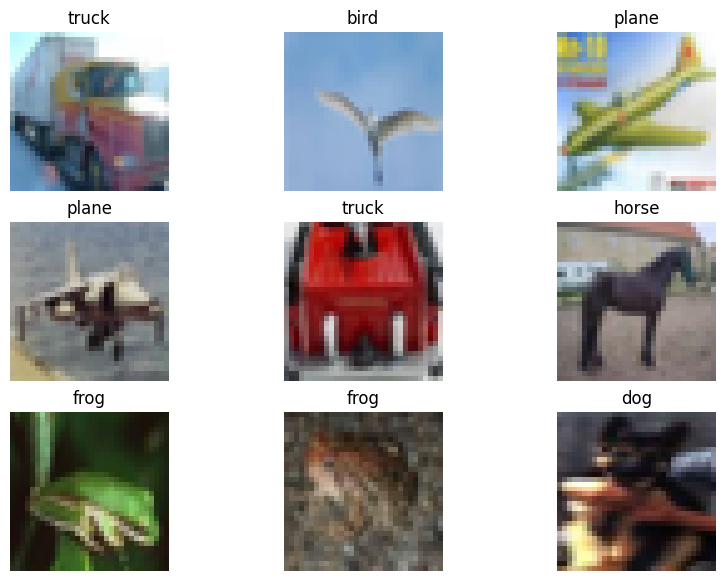

In [160]:
import matplotlib.pyplot as plt

plot_set = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()])  )

fig, axes = plt.subplots(3, 3, figsize = (10, 7))
for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        rand_int = np.random.randint(low = 0, high = len(train_set), size = (1,)).squeeze()
        img, label = plot_set[rand_int]
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'{classes[label]}')
        ax.axis('off')


### Task: Train FCN on the CIFAR-10 dataset and report test accuracy.


* Define FCN with input dimensions $32 \times 32 \times 3$ and output dimensions 10.
* In the forward function of the model, reshape the inputs from shape (B, 3, 32, 32) to (B, 32 * 32 * 3), where B is the batch size.

In [165]:
train_set[0][0].shape

torch.Size([3, 32, 32])

In [169]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # resize in case the input is an image
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        x = self.fc3(x)
        return x


input_size, num_classes = 32*32*3, 10

model = NeuralNet(input_size, hidden_size, num_classes)

# model, input output data should be on the same device
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):

    correct, total = 0, 0

    for i, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(imgs.to(device))
        loss_ = loss(outputs, labels.to(device))
        loss_.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    acc = correct / total

    print(f'Epoch {epoch} | Loss: {loss_:.4f} | Accuracy: {acc:.4f}')


model.eval()

correct = 0
total = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0 | Loss: 1.8396 | Accuracy: 0.2878
Epoch 1 | Loss: 1.6347 | Accuracy: 0.3867
Epoch 2 | Loss: 1.5847 | Accuracy: 0.4250
Epoch 3 | Loss: 1.5489 | Accuracy: 0.4497
Epoch 4 | Loss: 1.4763 | Accuracy: 0.4703
Epoch 5 | Loss: 1.4911 | Accuracy: 0.4848
Epoch 6 | Loss: 1.4614 | Accuracy: 0.4965
Epoch 7 | Loss: 1.4177 | Accuracy: 0.5120
Epoch 8 | Loss: 1.4030 | Accuracy: 0.5243
Epoch 9 | Loss: 1.4106 | Accuracy: 0.5322
Test Accuracy: 0.4971


# Problem 4: Implementing CNNs using Pytorch nn.Module

In this problem, we will implement LeNet CNN (https://en.wikipedia.org/wiki/LeNet) using Pytorch nn.Module to classify (a) CIFAR-10 dataset and (b) Galaxy dataset

In [170]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## (a) CIFAR-10 dataset

Load data

In [172]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]
     )

batch_size = 128

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Task: Define the layers of the LeNet architecture using the following torch layers:
* nn.Conv2d with 3 input channel, 6 output channels, and a kernel size of 5.
* nn.MaxPool2d with a kernel size of 2.
* nn.Conv2d with 6 input channels, 16 output channels, and a kernel size of 5.
* nn.MaxPool2d with a kernel size of 2.
* nn.Linear with 16 * 5 * 5 input features and 120 output features.
* nn.Linear with 120 input features and 84 output features.
* nn.Linear with 84 input features and 10 output features.
In the forward method, define the forward pass of the LeNet architecture using the layers defined in __init__.

In [173]:
num_classes = 10

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.maxpool2d = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.maxpool2d(torch.sigmoid(self.conv1(x)))
        x = self.maxpool2d(torch.sigmoid(self.conv2(x)))

        x = torch.sigmoid(self.fc1(x.view(x.size(0),-1)))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

Hyperparameters

In [175]:
learning_rate = 0.01
num_classes = 10
num_epochs = 10
n_total_steps = len(train_loader)

### Task: Train LeNet on the CIFAR-10 dataset and report test accuracy.

In [176]:
model = LeNet().float().to(device)

# model, input output data should be on the same device
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    correct, total = 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(imgs.to(device))
        loss_ = loss(outputs, labels.to(device))
        loss_.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    acc = correct/total

    print(f'Epoch {epoch} | Loss: {loss_:.4f} | Accuracy: {acc:.4f}')



model.eval()

correct = 0
total = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0 | Loss: 2.3023207188 | Accuracy: 0.0991600000
Epoch 1 | Loss: 2.3124597073 | Accuracy: 0.0991000000
Epoch 2 | Loss: 2.3035187721 | Accuracy: 0.0988200000
Epoch 3 | Loss: 2.3171153069 | Accuracy: 0.0995800000
Epoch 4 | Loss: 2.2862877846 | Accuracy: 0.0991800000
Epoch 5 | Loss: 2.3060297966 | Accuracy: 0.0984400000
Epoch 6 | Loss: 2.3207345009 | Accuracy: 0.0991400000
Epoch 7 | Loss: 2.3018946648 | Accuracy: 0.0992800000
Epoch 8 | Loss: 2.2997505665 | Accuracy: 0.0982000000
Epoch 9 | Loss: 2.3031287193 | Accuracy: 0.0993400000
Test Accuracy: 0.1000


## (b) Galaxy dataset

In [1]:
!pip install -q tensorflow
!pip install -q tensorflow_probability
!pip install -q git+https://github.com/henrysky/astroNN.git

In [177]:
from astroNN.datasets import load_galaxy10sdss
from astroNN.datasets.galaxy10sdss import galaxy10cls_lookup, galaxy10_confusion
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [178]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [179]:
images, labels = load_galaxy10sdss()
images = images.astype(np.float32)

images = images.transpose( (0, 3, 1, 2) )

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

/Users/hyunwoooh/.astroNN/datasets/Galaxy10.h5 was found!


Let us check the image size and number of classes

In [180]:
print(f'Image size: {train_images.shape}, Classes: {np.unique(train_labels)}')

Image size: (19606, 3, 69, 69), Classes: [0 1 2 3 4 5 6 7 8 9]


Let us explore some images from the dataset.

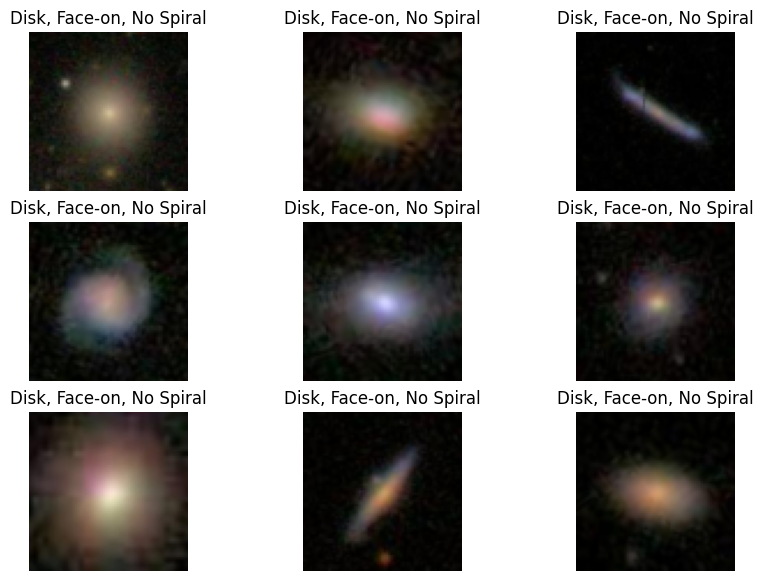

In [181]:
import matplotlib.pyplot as plt

num_plots = 3
fig, axes = plt.subplots(num_plots, num_plots, figsize = (10, 7))

for i in range(num_plots):
    for j in range(num_plots):
        ax = axes[i][j]
        rand_int = np.random.randint(low = 0, high = len(train_images), size = (1,)).squeeze()
        img = train_images[rand_int] / 255.0
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set_title(f'{galaxy10cls_lookup(rand_int)}')
        ax.axis('off')


Create a torch dataset for the Galaxy dataset

In [182]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]
        return image, label

batch_size = 512

train_dataset = GalaxyDataset(train_images, train_labels)
test_dataset = GalaxyDataset(test_images, test_labels)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


### Task: Define the layers of the LeNet architecture using the following torch layers:

* nn.Conv2d with 3 input channel, 8 output channels, and a kernel size of 5.
* nn.MaxPool2d with a kernel size of 2.
* nn.Conv2d with 8 input channels, 16 output channels, and a kernel size of 5.
* nn.MaxPool2d with a kernel size of 2.
* nn.Linear with 3136 input features and 120 output features.
* nn.Linear with 240 input features and 84 output features.
* nn.Linear with 84 input features and 10 output features.



In [183]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)

        self.maxpool2d = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(3136, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.ReLU = nn.ReLU()

    def forward(self, x):
        x = self.maxpool2d(torch.sigmoid(self.conv1(x)))
        x = self.maxpool2d(torch.sigmoid(self.conv2(x)))

        x = torch.sigmoid(self.fc1(x.view(x.size(0),-1)))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)

        return x

Hyperparameters

In [185]:
learning_rate = 1e-3
num_classes = 10
num_epochs = 10
n_total_steps = len(train_loader)

### Task: Train LeNet on the Galaxy classification dataset report test accuracy.

In [186]:
model = LeNet().float().to(device)

# model, input output data should be on the same device
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)


for epoch in range(num_epochs):
    correct, total = 0, 0
    for i, (imgs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(imgs.to(device))
        loss_ = loss(outputs, labels.to(device))
        loss_.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    acc = correct/total

    print(f'Epoch {epoch} | Loss: {loss_:.10f} | Accuracy: {acc:.10f}')



model.eval()

correct = 0
total = 0

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 0 | Loss: 2.1571409702 | Accuracy: 0.2188615730
Epoch 1 | Loss: 2.0895683765 | Accuracy: 0.3202591044
Epoch 2 | Loss: 2.0175912380 | Accuracy: 0.3202591044
Epoch 3 | Loss: 1.9901955128 | Accuracy: 0.3202591044
Epoch 4 | Loss: 2.0371153355 | Accuracy: 0.3202591044
Epoch 5 | Loss: 1.9175691605 | Accuracy: 0.3202591044
Epoch 6 | Loss: 1.9044097662 | Accuracy: 0.3202591044
Epoch 7 | Loss: 1.8355157375 | Accuracy: 0.3202591044
Epoch 8 | Loss: 1.8568910360 | Accuracy: 0.3202591044
Epoch 9 | Loss: 1.8656339645 | Accuracy: 0.3202591044
Test Accuracy: 0.3295
